Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from glob import glob
import random

# Suppress future warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
### your code goes here, you can use training or validation data to visualize

# Custom Functions for plotting

# Function to generate image map
def generate_image_map(image_ds,batch_num=1):
  # Dictionary to store one image per label (0 to 9)
  label_image_map = {}
  # Iterate through the dataset without limiting the number of batches
  for images, labels in image_ds.skip(batch_num-1).take(1):
      # Loop through each image and its corresponding label
      for image, label in zip(images.numpy(), labels.numpy()):
          # If we haven't already stored an image for this label
          if label not in label_image_map:
              label_image_map[label] = image  # Store the image with the unique label
          # Stop once we have one image for each label (0 to 9)
          if len(label_image_map) == 10:
              break  # Exit the inner loop if all 10 labels are found
      if len(label_image_map) == 10:
          break  # Exit outer loop once all labels are covered
  # Sort the dictionary by keys
  sorted_image_map=dict(sorted(label_image_map.items()))
  # Display the keys of the dictionary to check which labels have been collected
  print("Labels found:", sorted_image_map.keys())
  return sorted_image_map


# Function to plot sample images
def plot_sample_images(class_names, label_image_map):
  plt.figure(figsize=(20, 10))
  for idx, (label, image) in enumerate(label_image_map.items()):
      plt.subplot(2, 5, idx + 1)  # Create a 2x5 grid for the images
      plt.imshow(image.astype("uint8"))  # Display the image
      plt.title(f"Class: {class_names[label]}")  # Display the class name
      plt.axis('off')  # Turn off the axis
  # Show the plot with all images
  plt.tight_layout()
  plt.show()

In [10]:
# Genarate random batch number between 0 and 10
batch_num=random.randint(1,11)
batch_num

4

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


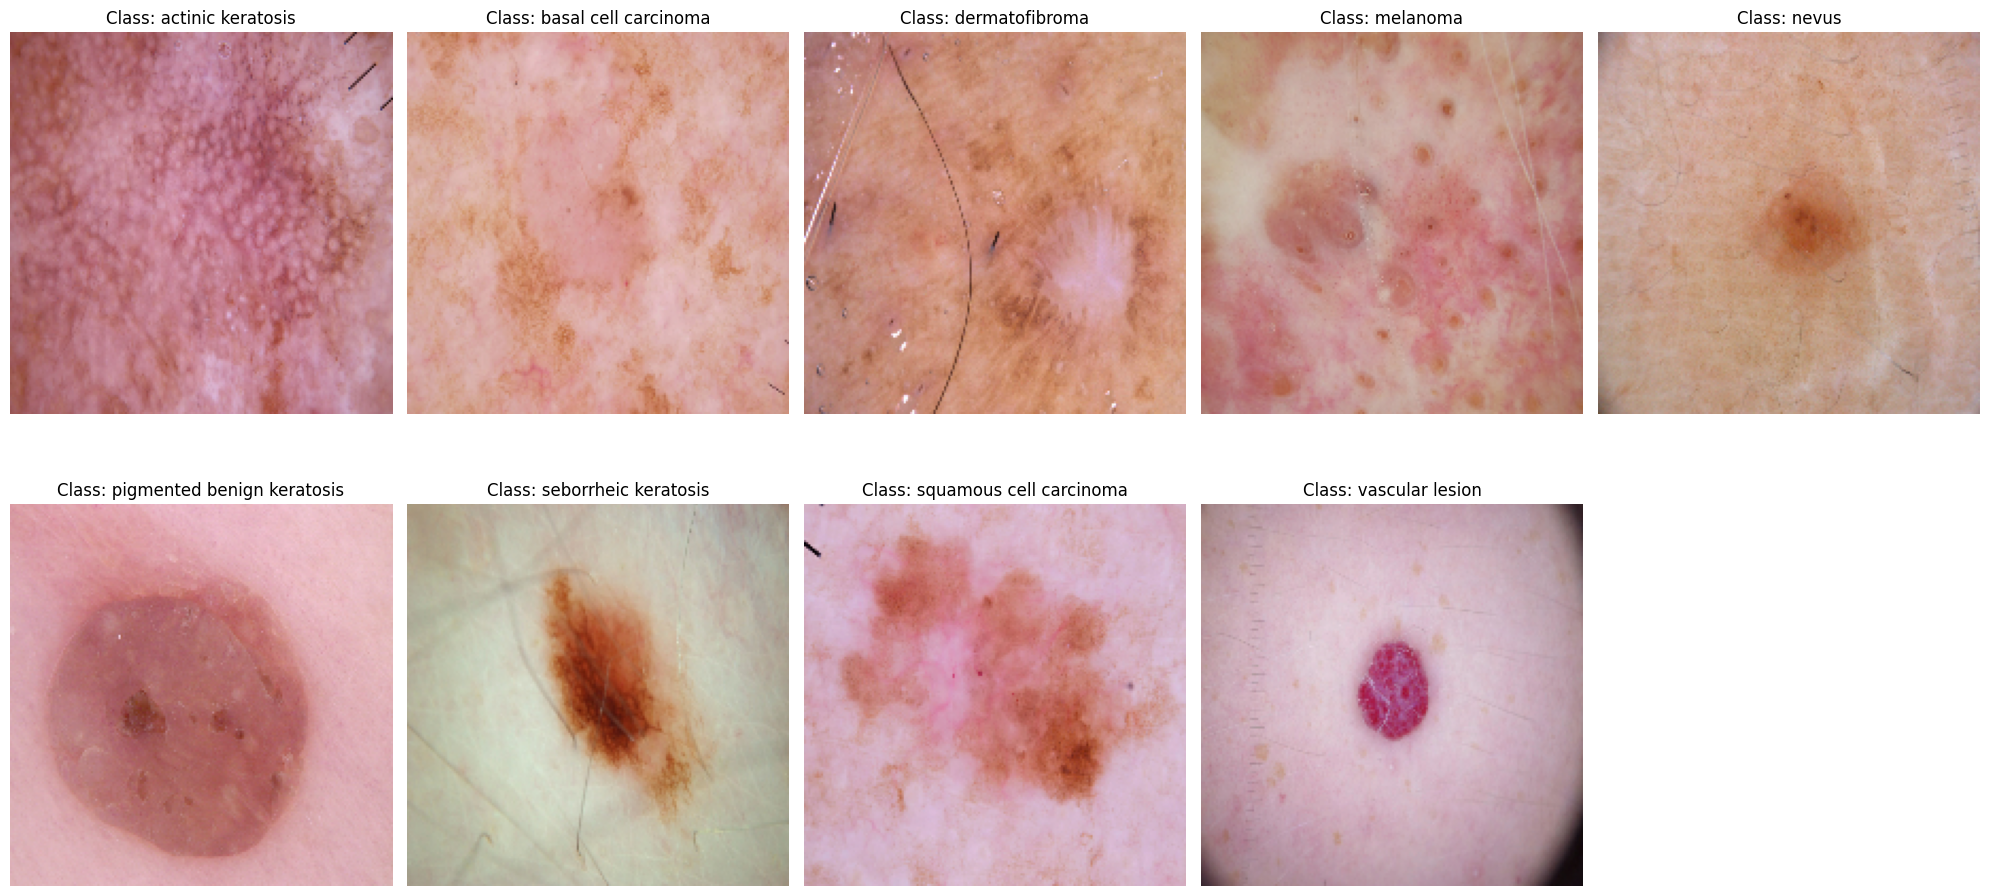

In [11]:
# Visualize Train Data
train_image_map=generate_image_map(train_ds,batch_num)
plot_sample_images(class_names,train_image_map)

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


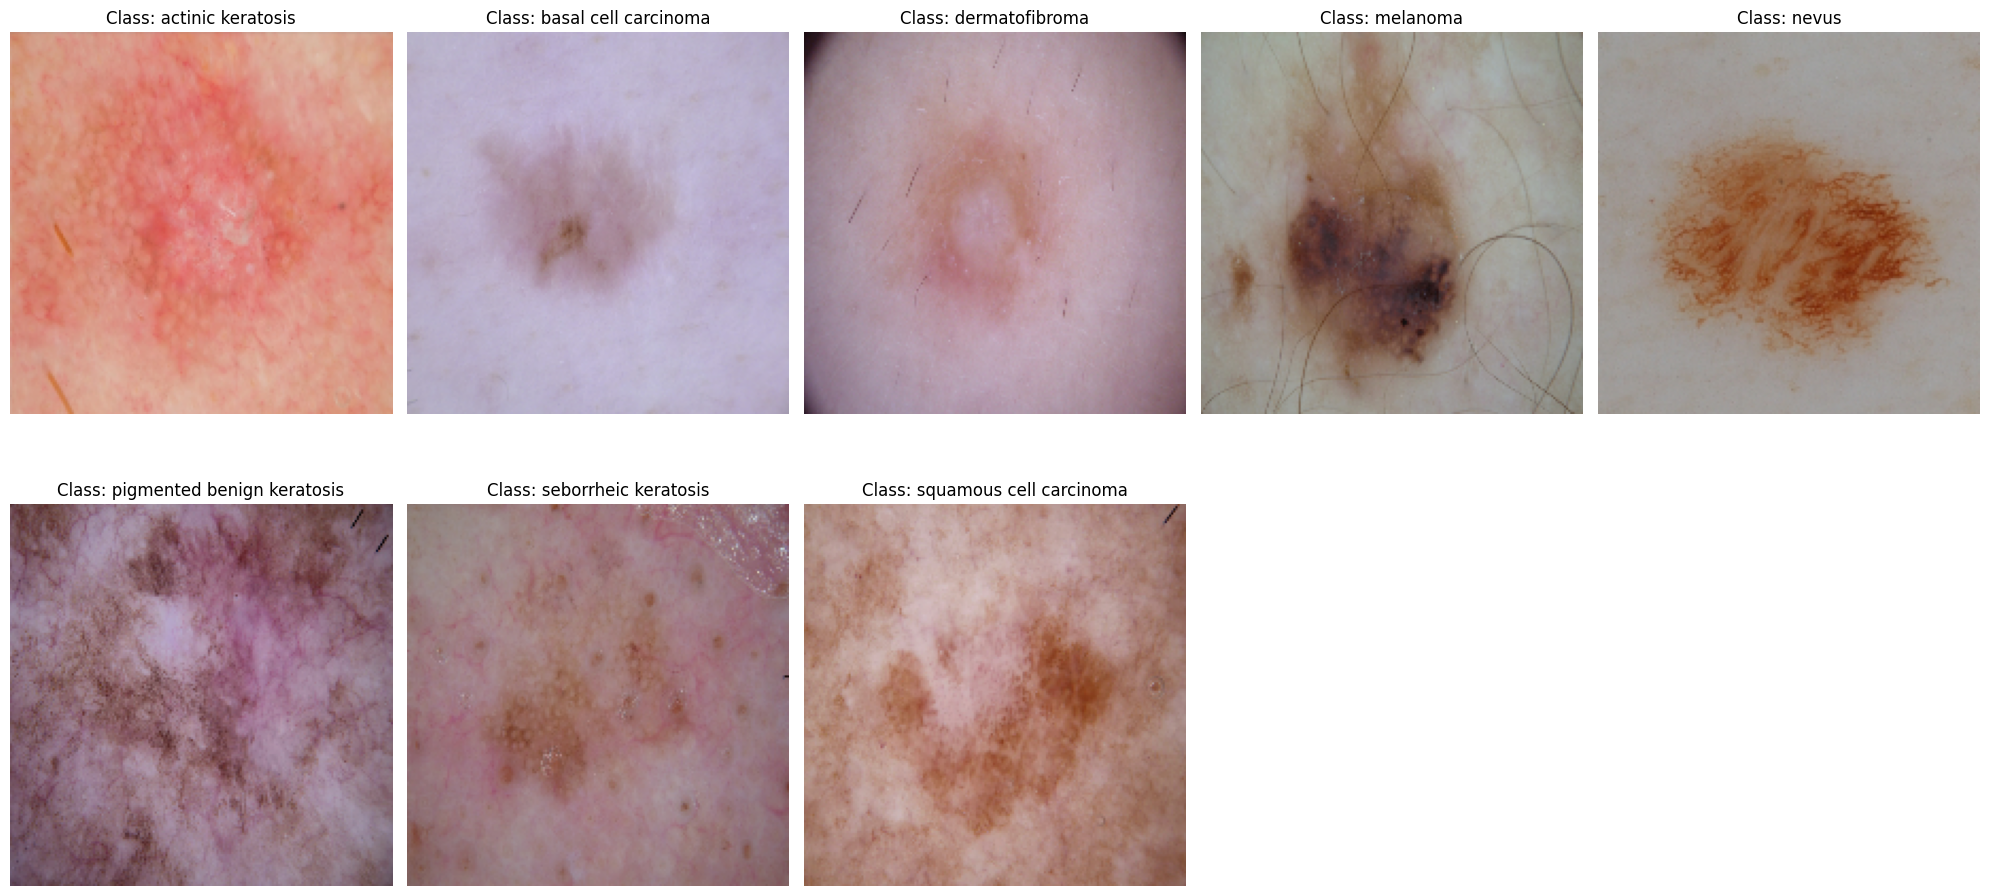

In [12]:
# Visualize Validation Data
val_image_map=generate_image_map(val_ds,batch_num)
plot_sample_images(class_names,val_image_map)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 1 - Base Model

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
base_model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
base_model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# First Part
base_model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
base_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
# Second Part
base_model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
base_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
# Third Part
base_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding second Convolution layer
base_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
# Flattening the output
base_model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
base_model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
# Output Layer
base_model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
base_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_3 (Conv2D)              │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
base_model_history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 560ms/step - accuracy: 0.2292 - loss: 2.1929 - val_accuracy: 0.3803 - val_loss: 1.7209
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4219 - loss: 1.6285 - val_accuracy: 0.4631 - val_loss: 1.4867
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5006 - loss: 1.4454 - val_accuracy: 0.5190 - val_loss: 1.4160
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5451 - loss: 1.2863 - val_accuracy: 0.5503 - val_loss: 1.3117
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5705 - loss: 1.2205 - val_accuracy: 0.5347 - val_loss: 1.3851
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6065 - loss: 1.1198 - val_accuracy: 0.5459 - val_loss: 1.3528
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6160 - loss: 1.0869 - val_accuracy: 0.5436 - val_loss: 1.4261
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6583 - loss: 0.9657 - val_accuracy: 0.5324 

### Visualizing training results

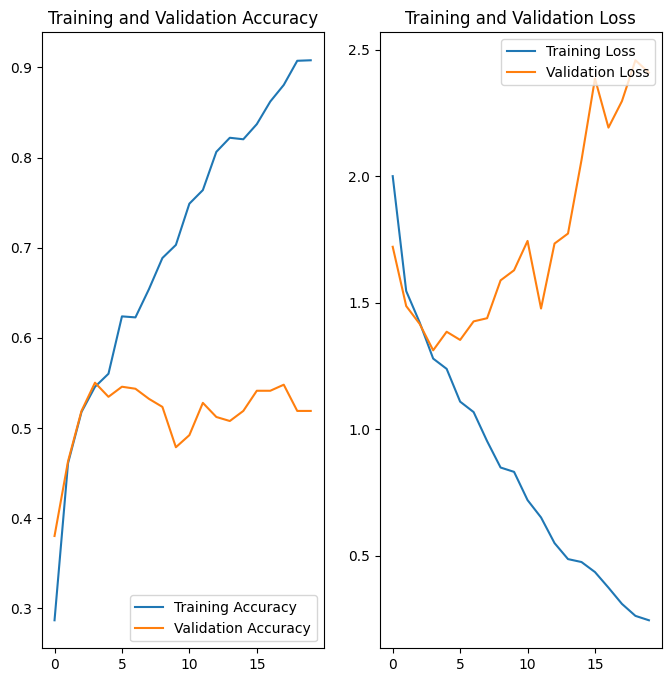

In [18]:
acc = base_model_history.history['accuracy']
val_acc = base_model_history.history['val_accuracy']

loss = base_model_history.history['loss']
val_loss = base_model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
- The training accuracy steadily improve to 88-90% by the 20th epoch, indicating that - the model is learning and fitting the training data well.
- The validation accuracy, on the other hand, peaks at around 55% and - then stagnates or decreases by the 20th epoch. This shows that the model - is not generalizing well to unseen data and starts to overfit after a - certain point.
- While the training loss continues to drop, the validation loss increases significantly over time by the 20th epoch.

<b><i>The model is overfitting, as indicated by the widening gap between the training and validation performance</i></b>

## Model 2 - Base Model with Data Augmentation

### Data augmentation

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=123 ),
  layers.RandomRotation(0.2, seed=123),
  layers.RandomZoom(0.2, seed=123),
] , name="Data_Augmentation_Layer")

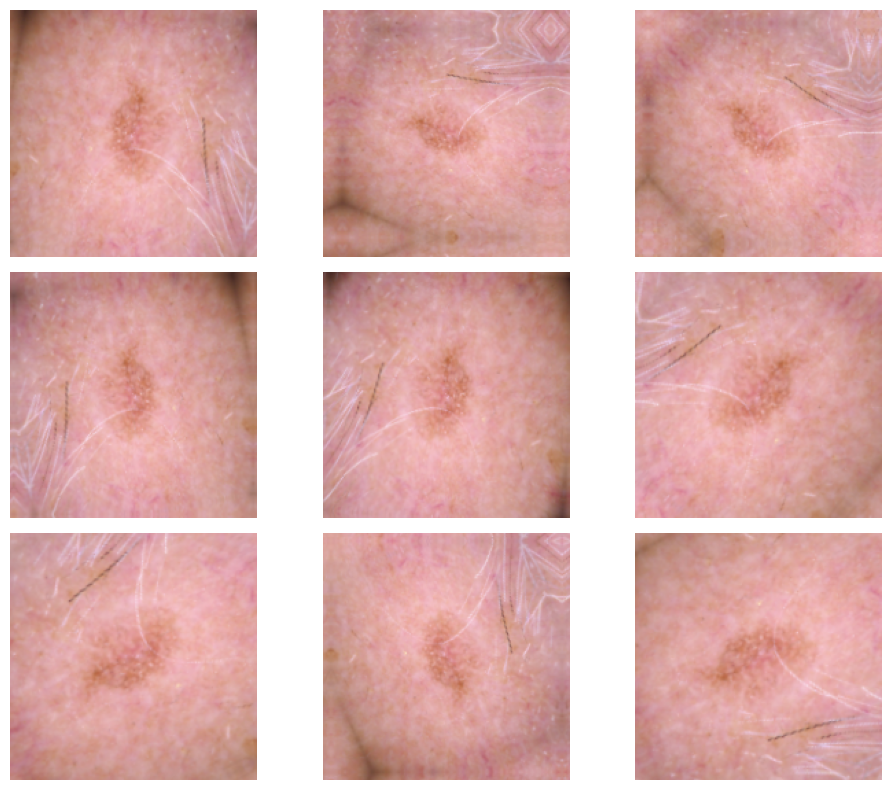

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
random_num=random.randint(1,11)
# Your code goes here
plt.figure(figsize=(10, 8))
for images, _ in train_ds.skip(random_num-1).take(random_num):
  for i in range(9):
    augmented_images = data_augmentation(images) # data augmenatation
    ax = plt.subplot(3, 3, i + 1) # Create a 3x3 grid for the images
    plt.imshow(augmented_images[random_num].numpy().astype("uint8")) # Display the image
    plt.axis("off") # Turn off the axis
# Show the plot with all images
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
aug_layer_model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
aug_layer_model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
aug_layer_model.add( data_augmentation )
# First Part
aug_layer_model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
aug_layer_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
# Second Part
aug_layer_model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
aug_layer_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
# Third Part
aug_layer_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding second Convolution layer
aug_layer_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
aug_layer_model.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts
# Flattening the output
aug_layer_model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
aug_layer_model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
aug_layer_model.add(layers.Dropout(0.30,name="Dropout_2")) # adding dropouts
# Output Layer
aug_layer_model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

### Compiling the model

In [22]:
## Your code goes here
aug_layer_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
aug_layer_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_3 (Conv2D)              │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
aug_layer_history = aug_layer_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1805 - loss: 2.2050 - val_accuracy: 0.2528 - val_loss: 1.9497
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3060 - loss: 1.9401 - val_accuracy: 0.3624 - val_loss: 1.8856
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3647 - loss: 1.7991 - val_accuracy: 0.3289 - val_loss: 1.8082
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4126 - loss: 1.6999 - val_accuracy: 0.5123 - val_loss: 1.4989
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4521 - loss: 1.5349 - val_accuracy: 0.5213 - val_loss: 1.4535
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4668 - loss: 1.5520 - val_accuracy: 0.4899 - val_loss: 1.4690
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4948 - loss: 1.4507 - val_accuracy: 0.5347 - val_loss: 1.4005
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5024 - loss: 1.4368 - val_accuracy: 0.5324 - v

### Visualizing the results

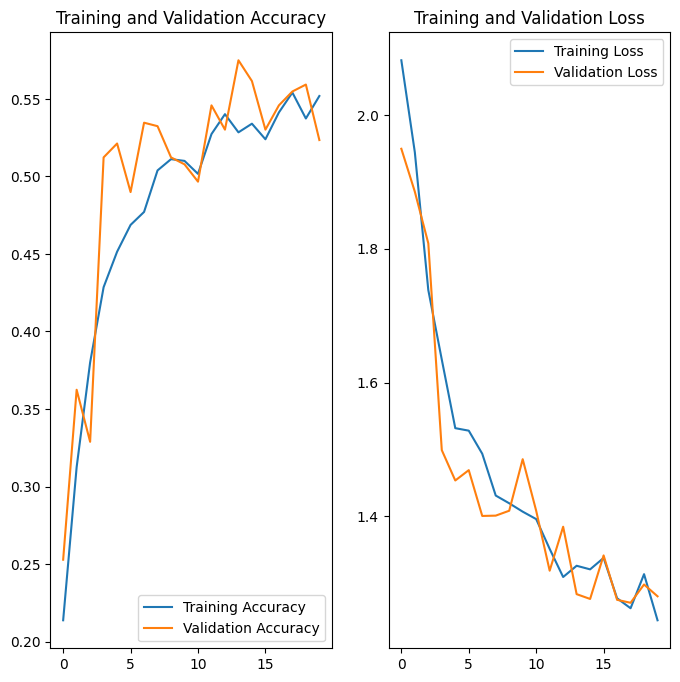

In [25]:
acc = aug_layer_history.history['accuracy']
val_acc = aug_layer_history.history['val_accuracy']

loss = aug_layer_history.history['loss']
val_loss = aug_layer_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings:
- The training accuracy and validation accuracy are almost the same but are both quite low, indicating that the model is likely underfitting.
- The training loss is very low, while the validation loss fluctuates significantly.
- These results suggest that the current model is not performing well and requires improvement.
- Additionally, addressing the issue of class imbalance could further - improve the model's performance.

## Model 3 - Base Model with Data Augmentation after fixing Data imbalacing

### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
list_images = []
for i in class_names:
    list_images.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

data = {'Class Names': class_names, 'Image Count': list_images}
original_df = pd.DataFrame(data)

In [27]:
original_df.head(9)

Class Names  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Answer - seborrheic keratosis has the least number of samples - 77
#### - Which classes dominate the data in terms proportionate number of samples?
Answer - pigmented benign keratosis dominates the data in terms proportionate number of samples - 462


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    class_path = path_to_training_dataset + i + '/output'
    # Check if 'output' folder exists and has the required number of images
    if os.path.exists(class_path) and len(os.listdir(class_path)) >= target_sample_size:
        print(f"Augmentation already done for class '{i}', skipping augmentation.")
    else:
        print(f"Augmenting class '{i}' as required samples are not present.")
    # Create an Augmentor pipeline for the class if augmentation is needed
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmenting class 'actinic keratosis' as required samples are not present.
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A68F06525C0>: 100%|██████████| 500/500 [00:05<00:00, 85.99 Samples/s]


Augmenting class 'basal cell carcinoma' as required samples are not present.
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A68F068B940>: 100%|██████████| 500/500 [00:06<00:00, 80.23 Samples/s]


Augmenting class 'dermatofibroma' as required samples are not present.
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A69001BF6D0>: 100%|██████████| 500/500 [00:07<00:00, 70.16 Samples/s]


Augmenting class 'melanoma' as required samples are not present.
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A69001DEC20>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Augmenting class 'nevus' as required samples are not present.
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2012x1956 at 0x7A68F068B550>: 100%|██████████| 500/500 [00:17<00:00, 28.66 Samples/s]


Augmenting class 'pigmented benign keratosis' as required samples are not present.
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6900361600>: 100%|██████████| 500/500 [00:06<00:00, 82.01 Samples/s]


Augmenting class 'seborrheic keratosis' as required samples are not present.
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A6900363C40>: 100%|██████████| 500/500 [00:09<00:00, 52.58 Samples/s]


Augmenting class 'squamous cell carcinoma' as required samples are not present.
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A69001BE8F0>: 100%|██████████| 500/500 [00:05<00:00, 88.07 Samples/s]


Augmenting class 'vascular lesion' as required samples are not present.
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A692C180C40>: 100%|██████████| 500/500 [00:05<00:00, 87.69 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000345.jpg_8252e77c-0b61-4b7c-8111-e28e1503b9b1.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000225.jpg_dbae134a-6015-4601-aacc-f8ee83536a80.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000027.jpg_c5363ea7-9d8e-4b69-82ee-0d2c523ed50e.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027580.jpg_0ed8611b-21ff-4beb-bc2e-5c90589ee917.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],ignore_index=True)

In [35]:
new_df['Label'].value_counts()

Label
nevus                         500
squamous cell carcinoma       500
basal cell carcinoma          500
seborrheic keratosis          500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
actinic keratosis             500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Todo:** Create your model (make sure to include normalization)

#### Create your model

In [39]:
## your code goes here
class_balanced_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
class_balanced_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
class_balanced_model.add(data_augmentation)

# First Part
class_balanced_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),padding="same", name="Conv2D_Layer_1"))  # adding first Convolution layer
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
class_balanced_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
class_balanced_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),padding="same", name="Conv2D_Layer_2"))  # adding second Convolution layer
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
class_balanced_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
class_balanced_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding second Convolution layer
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
class_balanced_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
class_balanced_model.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts

# Flattening the output
class_balanced_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
class_balanced_model.add(layers.Dense(units=128, name="FC_Layer_1"))
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
class_balanced_model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Output Layer
class_balanced_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
class_balanced_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# View the summary of all layers
class_balanced_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_3 (Conv2D)              │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,990,761 (15.22 MB)

 Trainable params: 3,990,281 (15.22 MB)

 Non-trainable params: 480 (1.88 KB)

#### **Todo:**  Train your model

In [42]:
epochs = 30
## Your code goes here, use 30 epochs.
class_balanced_history = class_balanced_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.3699 - loss: 1.7778 - val_accuracy: 0.1403 - val_loss: 2.4415
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.4785 - loss: 1.3766 - val_accuracy: 0.1960 - val_loss: 2.3007
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5072 - loss: 1.2863 - val_accuracy: 0.3823 - val_loss: 1.6378
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5493 - loss: 1.1734 - val_accuracy: 0.5464 - val_loss: 1.1655
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.5791 - loss: 1.1257 - val_accuracy: 0.3846 - val_loss: 2.0536
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.5982 - loss: 1.0877 - val_accuracy: 0.5984 - val_loss: 1.0578
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6029 - loss: 1.0263 - val_accuracy: 0.4729 - val_loss: 1.6689
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.6125 - loss: 1.0199 - 

#### **Todo:**  Visualize the model results

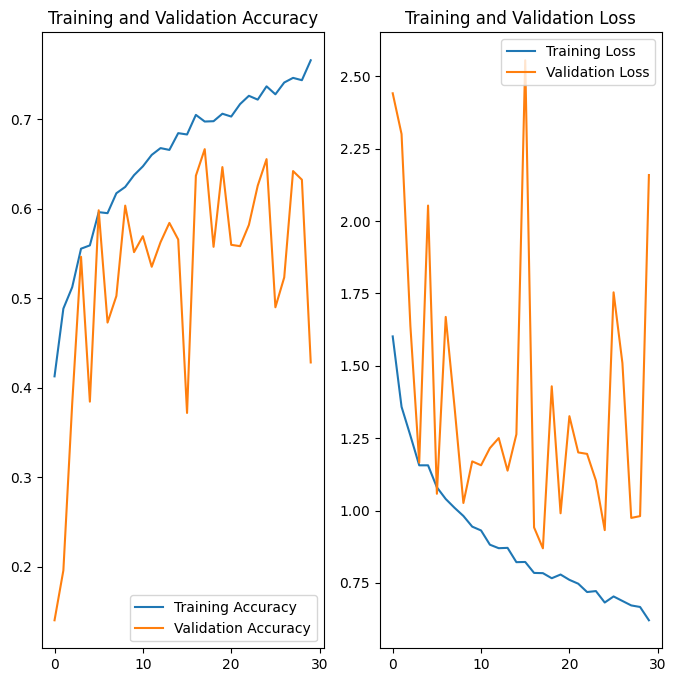

In [43]:
acc = class_balanced_history.history['accuracy']
val_acc = class_balanced_history.history['val_accuracy']

loss = class_balanced_history.history['loss']
val_loss = class_balanced_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 4 - Include Callbacks and adjust Dropouts ( gradually increase dropout percentages )

In [44]:
## your code goes here
lr_control_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
lr_control_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
lr_control_model.add(data_augmentation)

# First Part
lr_control_model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",  name="Conv2D_Layer_1"))  # adding first Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
lr_control_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="Conv2D_Layer_2"))  # adding second Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
lr_control_model.add(layers.Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu", name="Conv2D_Layer_3")) # adding second Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
lr_control_model.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts

# Flattening the output
lr_control_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
lr_control_model.add(layers.Dense(units=128, name="FC_Layer_1"))
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
lr_control_model.add(layers.Dropout(0.40, name="Dropout_2"))  # adding dropout

# Output Layer
lr_control_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
lr_control_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
lr_control_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_3 (Conv2D)              │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,990,761 (15.22 MB)

 Trainable params: 3,990,281 (15.22 MB)

 Non-trainable params: 480 (1.88 KB)

Train the model

In [45]:
epochs = 30
lr_control_history = lr_control_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.3227 - loss: 1.9563 - val_accuracy: 0.1151 - val_loss: 2.4938 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4519 - loss: 1.4551 - val_accuracy: 0.1544 - val_loss: 2.1484 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4855 - loss: 1.3547 - val_accuracy: 0.4306 - val_loss: 1.5579 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5145 - loss: 1.2966 - val_accuracy: 0.5212 - val_loss: 1.2251 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.5505 - loss: 1.2122 - val_accuracy: 0.5627 - val_loss: 1.1701 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5612 - loss: 1.1604 - val_accuracy: 0.5041 - val_loss: 1.2868 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.5705 - l

Visualize the model results

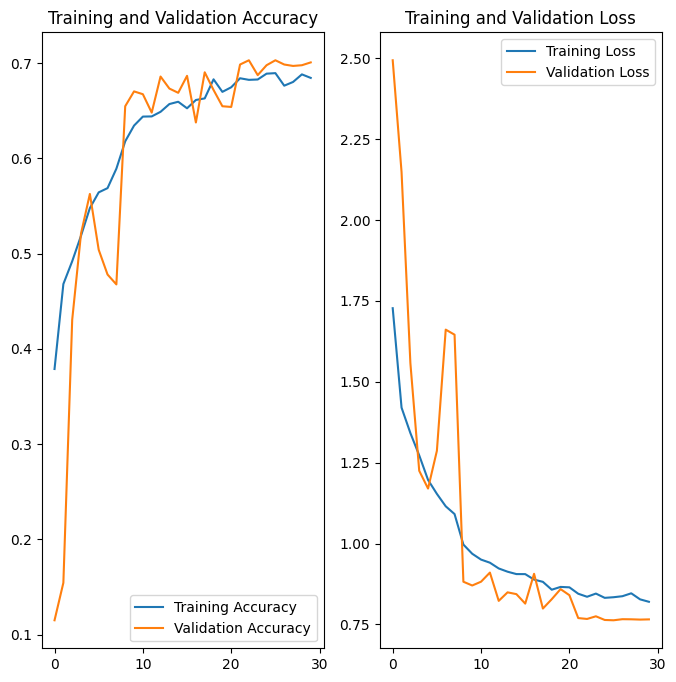

In [46]:
acc = lr_control_history.history['accuracy']
val_acc = lr_control_history.history['val_accuracy']

loss = lr_control_history.history['loss']
val_loss = lr_control_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

In Model 1, we observed significant overfitting, with high training accuracy (0.84) but much lower validation accuracy (0.55). Adding data augmentation in Model 2 helped reduce the gap between training and validation accuracy, but underfitting became a concern. Model 3, with class rebalancing, further reduced overfitting but slightly hindered validation performance.

Model 4, which introduced controlled learning rate, showed improved generalization, as indicated by a more balanced train and validation accuracy (0.63 vs. 0.61). Overall, class rebalancing and learning rate control contributed positively to the model’s stability.

## Model 5 - Let's try with little increased Learning rate and also include Callbacks

Create the Model

In [47]:
## your code goes here
increased_lr_control_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
increased_lr_control_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
increased_lr_control_model.add(data_augmentation)

# First Part
increased_lr_control_model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",  name="Conv2D_Layer_1"))  # adding first Convolution layer
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
increased_lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
increased_lr_control_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="Conv2D_Layer_2"))  # adding second Convolution layer
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
increased_lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
increased_lr_control_model.add(layers.Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu", name="Conv2D_Layer_3")) # adding second Convolution layer
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
increased_lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
increased_lr_control_model.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts

# Flattening the output
increased_lr_control_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
increased_lr_control_model.add(layers.Dense(units=128, name="FC_Layer_1"))
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
increased_lr_control_model.add(layers.Dropout(0.40, name="Dropout_2"))  # adding dropout

# Output Layer
increased_lr_control_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
increased_lr_control_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # Reduce learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
increased_lr_control_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_3 (Conv2D)              │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,990,761 (15.22 MB)

 Trainable params: 3,990,281 (15.22 MB)

 Non-trainable params: 480 (1.88 KB)

Train the model

In [48]:
epochs = 30
increased_lr_control_history = increased_lr_control_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.3195 - loss: 1.8947 - val_accuracy: 0.1507 - val_loss: 2.4844 - learning_rate: 0.0100
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4193 - loss: 1.5077 - val_accuracy: 0.3304 - val_loss: 1.6888 - learning_rate: 0.0100
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4557 - loss: 1.4242 - val_accuracy: 0.3660 - val_loss: 1.7847 - learning_rate: 0.0100
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.4767 - loss: 1.3495 - val_accuracy: 0.4729 - val_loss: 1.3282 - learning_rate: 0.0100
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.4828 - loss: 1.3025 - val_accuracy: 0.4009 - val_loss: 1.5791 - learning_rate: 0.0100
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4915 - loss: 1.3167 - val_accuracy: 0.4907 - val_loss: 1.2952 - learning_rate: 0.0100
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5145 - l

Visualize the model results

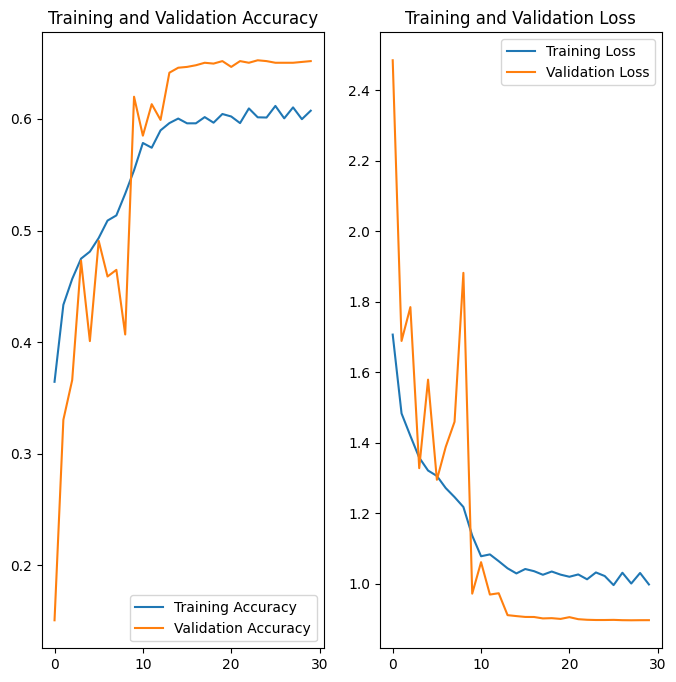

In [49]:
acc = increased_lr_control_history.history['accuracy']
val_acc = increased_lr_control_history.history['val_accuracy']

loss = increased_lr_control_history.history['loss']
val_loss = increased_lr_control_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 6 - Default Learning Rate and increased Epoch Value

In [50]:
## your code goes here
more_epoch_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
more_epoch_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
more_epoch_model.add(data_augmentation)

# First Part
more_epoch_model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",  name="Conv2D_Layer_1"))  # adding first Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
more_epoch_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="Conv2D_Layer_2"))  # adding second Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
more_epoch_model.add(layers.Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu", name="Conv2D_Layer_3")) # adding second Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
more_epoch_model.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts

# Flattening the output
more_epoch_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
more_epoch_model.add(layers.Dense(units=128, name="FC_Layer_1"))
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
more_epoch_model.add(layers.Dropout(0.40, name="Dropout_2"))  # adding dropout

# Output Layer
more_epoch_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
more_epoch_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
more_epoch_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_3 (Conv2D)              │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,990,761 (15.22 MB)

 Trainable params: 3,990,281 (15.22 MB)

 Non-trainable params: 480 (1.88 KB)

Train the model

In [51]:
epochs = 50
more_epoch_history = more_epoch_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.3338 - loss: 1.9139 - val_accuracy: 0.1975 - val_loss: 2.2794 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4766 - loss: 1.3905 - val_accuracy: 0.2754 - val_loss: 1.9509 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4976 - loss: 1.2932 - val_accuracy: 0.4239 - val_loss: 1.6065 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5260 - loss: 1.2412 - val_accuracy: 0.4714 - val_loss: 1.4383 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5693 - loss: 1.1472 - val_accuracy: 0.4039 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5773 - loss: 1.1198 - val_accuracy: 0.5783 - val_loss: 1.1147 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5927 - l

Visualize the model results

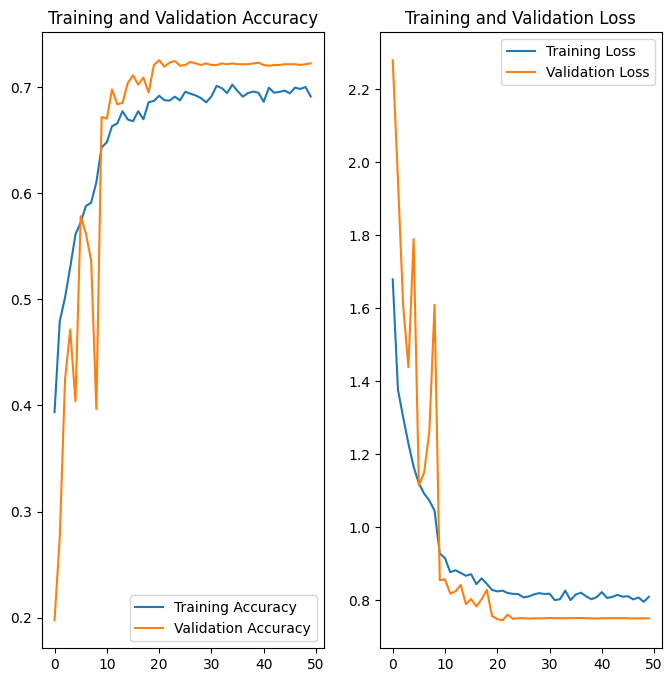

In [52]:
acc = more_epoch_history.history['accuracy']
val_acc = more_epoch_history.history['val_accuracy']

loss = more_epoch_history.history['loss']
val_loss = more_epoch_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 7 - Six Convolution layers with Batch Normalization and dropouts
Max Pooling layer after every two Convolution Layers

Create the Model

In [53]:
# Create the Model
six_layers_model = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
six_layers_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
six_layers_model.add(data_augmentation)

# First Part
six_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_1"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_2"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
six_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_1"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_2"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
six_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer


# Adding dropouts
six_layers_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
six_layers_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
six_layers_model.add(layers.Dense(units=128, name="FC_Layer_128N"))
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))

# Adding dropouts
six_layers_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
six_layers_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
six_layers_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
six_layers_model.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_1 (Conv2D)          │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_2 (Conv2D)          │ (None, 180, 180, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_1 (Conv2D)          │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_2 (Conv2D)          │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F_1 (Conv2D)          │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 45, 45, 64)          │              

 Total params: 4,039,705 (15.41 MB)

 Trainable params: 4,039,001 (15.41 MB)

 Non-trainable params: 704 (2.75 KB)

Train the model

In [54]:
epochs = 30
six_layers_history = six_layers_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - accuracy: 0.3450 - loss: 1.8521 - val_accuracy: 0.1032 - val_loss: 2.3618 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.4419 - loss: 1.4797 - val_accuracy: 0.2064 - val_loss: 2.1657 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.4896 - loss: 1.3613 - val_accuracy: 0.2851 - val_loss: 2.0822 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.5052 - loss: 1.3112 - val_accuracy: 0.5056 - val_loss: 1.2987 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.5227 - loss: 1.2228 - val_accuracy: 0.5219 - val_loss: 1.2387 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.5582 - loss: 1.1549 - val_accuracy: 0.5167 - val_loss: 1.2725 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.5

Visualize the model results

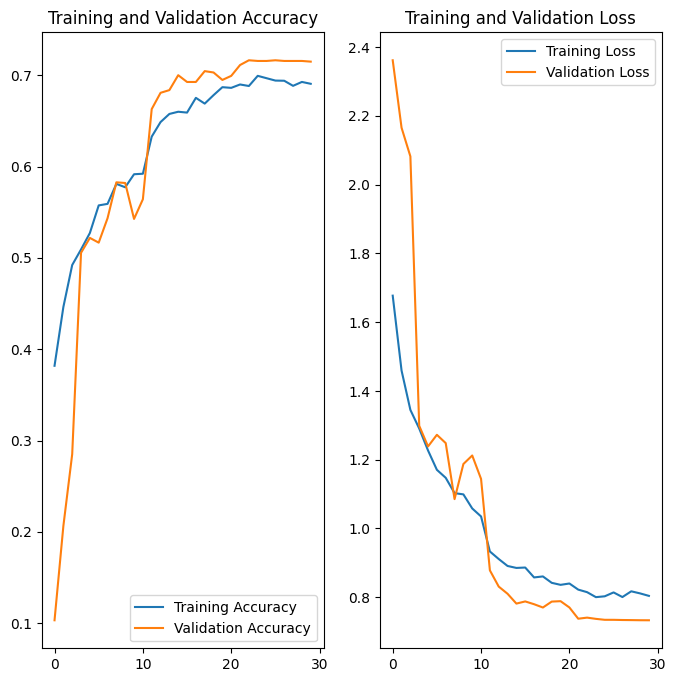

In [55]:
acc = six_layers_history.history['accuracy']
val_acc = six_layers_history.history['val_accuracy']

loss = six_layers_history.history['loss']
val_loss = six_layers_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 8 - Eight Convolution layers with Batch Normalization and dropouts

Create the Model

In [56]:
# Create the Model
eight_layers_model = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
eight_layers_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
eight_layers_model.add(data_augmentation)

# First Part
eight_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
eight_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
eight_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fourth Part
eight_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_128F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_128F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Adding dropouts
eight_layers_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
eight_layers_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
eight_layers_model.add(layers.Dense(units=128, name="FC_Layer_128N"))
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))

# Adding dropouts
eight_layers_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
eight_layers_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
eight_layers_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
eight_layers_model.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_1 (Conv2D)          │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_2 (Conv2D)          │ (None, 180, 180, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_1 (Conv2D)          │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_2 (Conv2D)          │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F_1 (Conv2D)          │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 45, 45, 64)          │              

 Total params: 2,279,705 (8.70 MB)

 Trainable params: 2,278,489 (8.69 MB)

 Non-trainable params: 1,216 (4.75 KB)

Train the model

In [57]:
epochs = 30
eight_layers_history = eight_layers_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.3145 - loss: 2.0169 - val_accuracy: 0.1284 - val_loss: 2.4207 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.4289 - loss: 1.5297 - val_accuracy: 0.2131 - val_loss: 2.1215 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.4809 - loss: 1.3849 - val_accuracy: 0.3036 - val_loss: 2.0338 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.5008 - loss: 1.3330 - val_accuracy: 0.4269 - val_loss: 1.6866 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.5184 - loss: 1.2631 - val_accuracy: 0.5397 - val_loss: 1.1908 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5331 - loss: 1.2160 - val_accuracy: 0.5843 - val_loss: 1.1443 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5

Visualize the model results

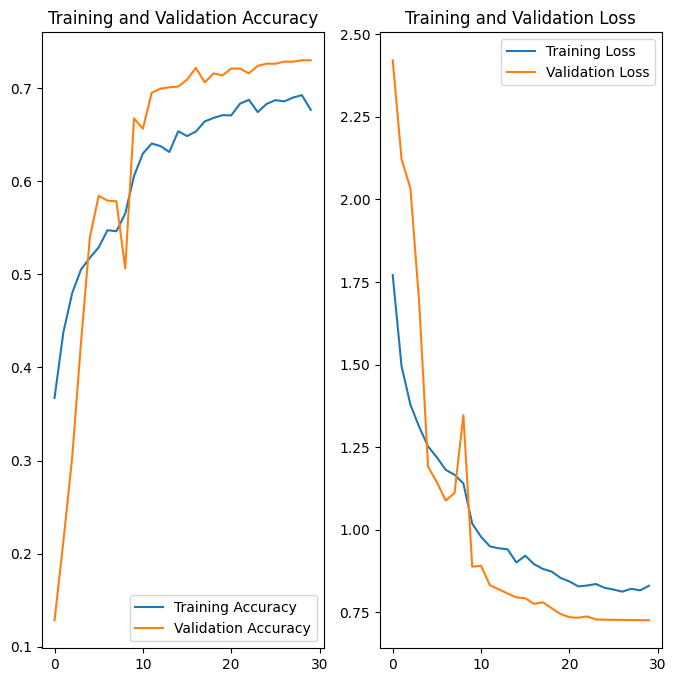

In [58]:
acc = eight_layers_history.history['accuracy']
val_acc = eight_layers_history.history['val_accuracy']

loss = eight_layers_history.history['loss']
val_loss = eight_layers_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 9 - Ten Convolution layers with Batch Normalization and dropouts

Create the Model

In [59]:
# Create the Model
ten_layers_model = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
ten_layers_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
ten_layers_model.add(data_augmentation)

# First Part
ten_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
ten_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
ten_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fourth Part
ten_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_128F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_128F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fifth Part
ten_layers_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_256F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_256F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Adding dropouts
ten_layers_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
ten_layers_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
ten_layers_model.add(layers.Dense(units=128, name="FC_Layer_128N"))
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))

# Adding dropouts
ten_layers_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
ten_layers_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
ten_layers_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
ten_layers_model.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_1 (Conv2D)          │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_2 (Conv2D)          │ (None, 180, 180, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_1 (Conv2D)          │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_2 (Conv2D)          │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F_1 (Conv2D)          │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 45, 45, 64)          │              

 Total params: 2,003,737 (7.64 MB)

 Trainable params: 2,001,497 (7.64 MB)

 Non-trainable params: 2,240 (8.75 KB)

Train the model

In [60]:
epochs = 30
ten_layers_history = ten_layers_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.3233 - loss: 1.9023 - val_accuracy: 0.1128 - val_loss: 3.1670 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.4291 - loss: 1.5114 - val_accuracy: 0.2346 - val_loss: 2.3301 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.4732 - loss: 1.4187 - val_accuracy: 0.5130 - val_loss: 1.3162 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.4796 - loss: 1.3442 - val_accuracy: 0.4670 - val_loss: 1.4618 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.5127 - loss: 1.2753 - val_accuracy: 0.4677 - val_loss: 1.3548 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5217 - loss: 1.2426
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.52

Visualize the model results

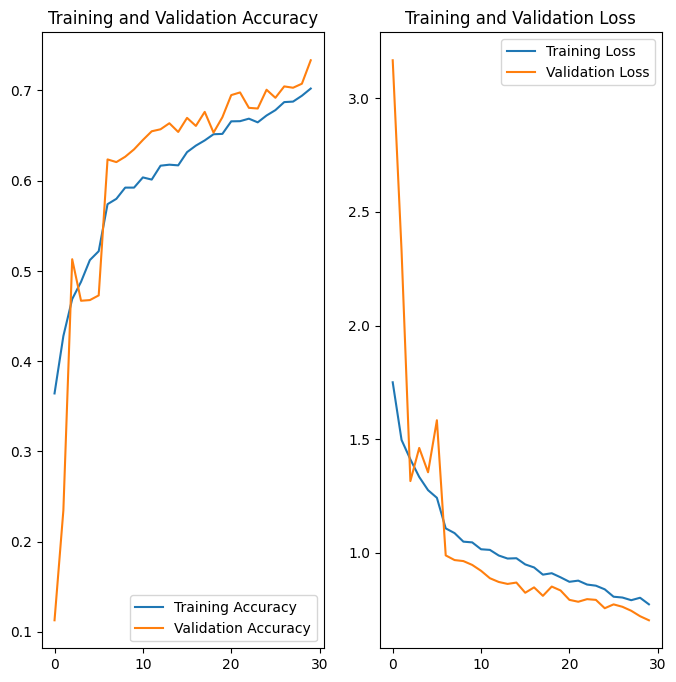

In [61]:
acc = ten_layers_history.history['accuracy']
val_acc = ten_layers_history.history['val_accuracy']

loss = ten_layers_history.history['loss']
val_loss = ten_layers_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 10 - Ten Convolution layers with Batch Normalization , dropouts and 50 epochs

Create the Model

In [65]:
# Create the Model
ten_layers_50_epochs_model = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
ten_layers_50_epochs_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
ten_layers_50_epochs_model.add(data_augmentation)

# First Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_16F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_32F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fourth Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_128F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_128F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fifth Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_256F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_256F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Adding dropouts
ten_layers_50_epochs_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
ten_layers_50_epochs_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
ten_layers_50_epochs_model.add(layers.Dense(units=128, name="FC_Layer_128N"))
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))

# Adding dropouts
ten_layers_50_epochs_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
ten_layers_50_epochs_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
ten_layers_50_epochs_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
ten_layers_50_epochs_model.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_1 (Conv2D)          │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_16F_2 (Conv2D)          │ (None, 180, 180, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_1 (Conv2D)          │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F_2 (Conv2D)          │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F_1 (Conv2D)          │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 45, 45, 64)          │              

 Total params: 2,003,737 (7.64 MB)

 Trainable params: 2,001,497 (7.64 MB)

 Non-trainable params: 2,240 (8.75 KB)

Train the model

In [66]:
epochs = 50
ten_layers_50_epochs_history = ten_layers_50_epochs_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.3051 - loss: 1.9908 - val_accuracy: 0.1084 - val_loss: 3.0529 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.4262 - loss: 1.5111 - val_accuracy: 0.2524 - val_loss: 1.9461 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.4651 - loss: 1.4159 - val_accuracy: 0.4647 - val_loss: 1.4011 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.4929 - loss: 1.3301 - val_accuracy: 0.4766 - val_loss: 1.3702 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.5109 - loss: 1.2948 - val_accuracy: 0.5449 - val_loss: 1.2057 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5319 - loss: 1.2336 - val_accuracy: 0.5226 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.5

Visualize the model results

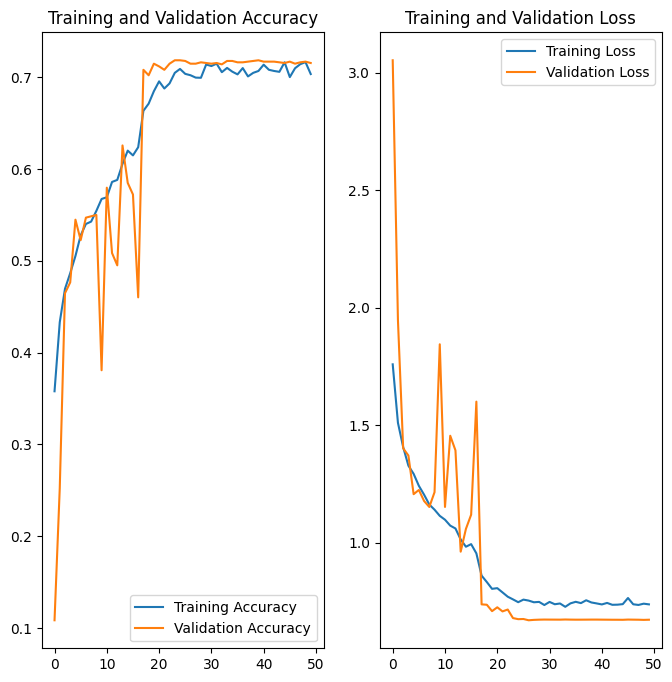

In [67]:
acc = ten_layers_50_epochs_history.history['accuracy']
val_acc = ten_layers_50_epochs_history.history['val_accuracy']

loss = ten_layers_50_epochs_history.history['loss']
val_loss = ten_layers_50_epochs_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction and Evaluation on Test Set

Test dataset creation

In [68]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,  # Path to the test data directory
    labels='inferred',  # Automatically infer labels from subdirectories
    label_mode='int',  # Labels will be integers
    class_names=None,  # Infer class names automatically
    color_mode='rgb',  # Images are in RGB
    batch_size=32,  # Batch size
    image_size=(img_height, img_width),  # Image size to resize to
    shuffle=False,  # Do not shuffle test data
    interpolation='bilinear',  # Interpolation method
    follow_links=False  # Follow symbolic links
)


Found 118 files belonging to 9 classes.


Prediction on Train Test Validation Set

In [69]:
# Function to evaluate accuracy on test data
def evaluate_accuracy(model_inp, data_inp):
    loss, accuracy = model_inp.evaluate(data_inp, verbose=0)  # Suppress verbose output
    return accuracy

# Dictionary containing models and their training histories
model_dict = {
    "Base Model": [base_model, base_model_history],
    "Base Model + Augmented Layers": [aug_layer_model, aug_layer_history],
    "Base Model + Augmented Layers + Balanced Class + Batch Normalization ": [class_balanced_model, class_balanced_history],
    "Base Model + Augmented Layers + Balanced Class + Batch Normalization + Controlled LR": [lr_control_model, lr_control_history],
    "Base Model + Augmented Layers + Balanced Class + Batch Normalization + Increased / Controlled LR": [increased_lr_control_model, increased_lr_control_history],
    "Base Model + Augmented Layers + Balanced Class + Controlled LR + More Epochs": [more_epoch_model, more_epoch_history],
    "Six Convolution Layers + Augmented Layers + Balanced Class +  Dropouts + Batch Normalization + Controlled LR": [six_layers_model,six_layers_history],
    "Eight Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR": [eight_layers_model,eight_layers_history],
    "Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR": [ten_layers_model,ten_layers_history],
    "Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + 50 Epochs + Batch Normalization + Controlled LR": [ten_layers_50_epochs_model,ten_layers_50_epochs_history]
}

# Create an empty report dataframe with the specified columns
report_df = pd.DataFrame(columns=['Model', 'Max Train Accuracy', 'Max Validation Accuracy', 'Test Accuracy'])

# Loop through each model and extract the required metrics
for key, items in model_dict.items():
    # Get the model and history
    model = items[0]
    history = items[1]

    # Get max train accuracy and validation accuracy
    max_train_acc = max(history.history['accuracy'])  # Maximum training accuracy
    max_val_acc = max(history.history['val_accuracy'])  # Maximum validation accuracy

    # Get test accuracy by evaluating the model on the test dataset
    test_acc = evaluate_accuracy(model, test_ds)  # Accuracy on the test data

    # Create a dictionary with the metrics
    df_dict = {
        'Model': key,  # Model name
        'Max Train Accuracy': round(max_train_acc, 2),  # Max training accuracy
        'Max Validation Accuracy': round(max_val_acc, 2),  # Max validation accuracy
        'Test Accuracy': round(test_acc, 2)  # Test accuracy
    }

    # Append row directly using pandas loc to avoid warnings
    report_df.loc[len(report_df)] = df_dict  # Append row directly

# Increment index to start from 1
report_df.index += 1

# Set max col displayed
pd.set_option('display.max_colwidth', None)

# Display the final sorted report dataframe
display(report_df.sort_values(by=['Test Accuracy'], ascending=False))

Model  \
9               Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR   
6                                              Base Model + Augmented Layers + Balanced Class + Controlled LR + More Epochs   
8             Eight Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR   
10  Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + 50 Epochs + Batch Normalization + Controlled LR   
7              Six Convolution Layers + Augmented Layers + Balanced Class +  Dropouts + Batch Normalization + Controlled LR   
4                                      Base Model + Augmented Layers + Balanced Class + Batch Normalization + Controlled LR   
5                          Base Model + Augmented Layers + Balanced Class + Batch Normalization + Increased / Controlled LR   
2                                                                                             Base Model + Augmented Layers   
1                                                                                                                Base Model   
3                                                     Base Model + Augmented Layers + Balanced Class + Batch Normalization    

    Max Train Accuracy  Max Validation Accuracy  Test Accuracy  
9                 0.70                     0.73           0.50  
6                 0.70                     0.73           0.49  
8                 0.69                     0.73           0.49  
10                0.72                     0.72           0.48  
7                 0.70                     0.72           0.47  
4                 0.69                     0.70           0.45  
5                 0.61                     0.65           0.45  
2                 0.55                     0.57           0.37  
1                 0.91                     0.55           0.33  
3                 0.77                     0.67           0.28

## Check and note library versions

In [70]:
print('numpy' , np.__version__)
print('pandas' ,pd.__version__)
print('matplotlib', matplotlib.__version__)
print('tensorflow' ,tf.__version__)
print('keras', keras.__version__)
print('augmentor', Augmentor.__version__)

numpy 1.26.4
pandas 2.2.2
matplotlib 3.7.1
tensorflow 2.17.0
keras 3.4.1
augmentor 0.2.12


## Conclusion

Based on the comparison of models, the following conclusions can be made:

- Model 9 (Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR) achieved the highest overall performance, with a validation accuracy of 0.73 and a test accuracy of 0.50. The combination of more layers, dropout regularization, and controlled learning rates made this model the best at generalizing to unseen data.
- Model 10 (Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + 50 Epochs + Batch Normalization + Controlled LR) had the highest training accuracy (0.72 validation accuracy, 0.48 test accuracy). Although training for more epochs improved training accuracy, the model didn’t generalize as well as Model 9, indicating that increasing the number of epochs alone may not significantly improve test performance.
- Models 6 and 8 both performed well with 0.73 validation accuracy and 0.49 test accuracy, suggesting that adding complexity in terms of convolution layers, balanced class handling, and dropout rates enhances performance.
- Model 7 (Six Convolution Layers) also showed solid results with a 0.72 validation accuracy and 0.47 test accuracy, but slightly lower than the deeper models.
- Models 4 and 5 had moderate performance, achieving validation accuracies of 0.70 and 0.65, respectively, with a test accuracy of 0.45. These models underline the importance of deeper architectures and more sophisticated regularization techniques for achieving better results.
- Base Models (1, 2, 3) suffered from overfitting, especially Model 1, which had a high training accuracy (0.91) but very low test accuracy (0.33). This confirms that deeper architectures with data augmentation and dropout regularization are essential for better generalization.

- In summary, deeper convolutional models with controlled learning rates, batch normalization, and dropout regularization, like Model 9, performed the best. While more epochs can help in training accuracy (Model 10), they do not always lead to better test performance.

- Overall, applying data augmentation, class balancing, learning rate control, dropout optimization, and deeper architectures significantly enhanced the performance of the CNN models for melanoma detection, with Model 8 emerging as the most balanced in terms of validation and test performance. Further optimization could continue to improve this performance.

### Delete Augmented Images - /output folders

In [71]:
# Delete all augmented images at the end of the notebook
import shutil  #  import shutil
for i in class_names:
    output_folder = path_to_training_dataset + i + '/output'

    # Check if the folder exists before attempting to delete
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)  # Recursively delete the entire output folder
        print(f"Deleted augmented images for class '{i}' from {output_folder}")
    else:
        print(f"No augmented images found for class '{i}', skipping deletion.")

Deleted augmented images for class 'actinic keratosis' from /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output
Deleted augmented images for class 'basal cell carcinoma' from /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output
Deleted augmented images for class 'dermatofibroma' from /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output
Deleted augmented images for class 'melanoma' from /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output
Deleted augmented images for class 'nevus' from /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/outp

<div align="center">------ End of Notebook -----